# CLASSIFY Credit Card Risk (RF)

In [1]:
#import Neccessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import datetime

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV

#import required accuracy metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
cr = pd.read_csv('/content/credit_record.csv')
cr.head(3)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0


In [3]:
application = pd.read_csv('/content/application_record.csv')
application.head(3)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


In [4]:
# merging 2 datasets
df = pd.merge(cr,application, on =['ID'], how='inner')
df.head(6)

,ID,MONTHS_BALANCE,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008804,-1,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008804,-2,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
3,5008804,-3,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
4,5008804,-4,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5,5008804,-5,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


In [5]:

#lets check the shape 
print('Shape of train dataset:',df.shape)

Shape of train dataset: (777715, 20)


In [6]:
df.drop_duplicates(keep = 'first',inplace=True)
print(df.shape)

(777715, 20)


In [7]:
# checking missing values
df.isnull().sum()[df.isnull().sum()>0]

OCCUPATION_TYPE    240048
dtype: int64

In [8]:
# dealing with missing values
df['OCCUPATION_TYPE'].fillna('others',inplace=True)

In [9]:
def calc_day_of_birth (day_num):
    today = date.today() 
    birthDay = (today + timedelta(days=day_num)).strftime('%Y-%m-%d')
    return birthDay
    
def calc_day_of_employed(day_num):
    today = date.today() 
    employedDay = (today + timedelta(days=day_num)).strftime('%Y-%m-%d')
    result = 0
    if employedDay > date.today().strftime('%Y-%m-%d') :
         result = 0
    else:
         result = employedDay
    return result

def get_label_for_data(status):
    if status in (2,3,4,5):
        return 1  # Risky
    else:
        return 0 # Not Risky

In [10]:
from datetime import date,datetime, timedelta
#get the day of birth for each person   
df['BIRTH_DAY']   = df['DAYS_BIRTH'].apply(calc_day_of_birth)
#get the day of birth for each person   
df['EMPLOYED_DAY']   = df['DAYS_EMPLOYED'].apply(calc_day_of_employed)

In [11]:
# replacing the value of C,X to numeric value 
df['STATUS'].replace({'C': 6, 'X' : 7}, inplace=True)
df['STATUS']=df['STATUS'].astype(int)

In [12]:
df['TARGET'] = df['STATUS'].apply(get_label_for_data)

In [13]:
df['TARGET'].unique()

array([0, 1])

In [14]:
#drop un nessesary columns
df = df.drop(['ID','DAYS_BIRTH','MONTHS_BALANCE','DAYS_EMPLOYED','EMPLOYED_DAY','BIRTH_DAY','STATUS','FLAG_MOBIL'],axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777715 entries, 0 to 777714
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          777715 non-null  object 
 1   FLAG_OWN_CAR         777715 non-null  object 
 2   FLAG_OWN_REALTY      777715 non-null  object 
 3   CNT_CHILDREN         777715 non-null  int64  
 4   AMT_INCOME_TOTAL     777715 non-null  float64
 5   NAME_INCOME_TYPE     777715 non-null  object 
 6   NAME_EDUCATION_TYPE  777715 non-null  object 
 7   NAME_FAMILY_STATUS   777715 non-null  object 
 8   NAME_HOUSING_TYPE    777715 non-null  object 
 9   FLAG_WORK_PHONE      777715 non-null  int64  
 10  FLAG_PHONE           777715 non-null  int64  
 11  FLAG_EMAIL           777715 non-null  int64  
 12  OCCUPATION_TYPE      777715 non-null  object 
 13  CNT_FAM_MEMBERS      777715 non-null  float64
 14  TARGET               777715 non-null  int64  
dtypes: float64(2), in

In [17]:
df.shape

(777715, 15)

# Data processing

## Apply label encoder to target variable

In [18]:
from sklearn.preprocessing import LabelEncoder
leb_enc = LabelEncoder()
df2 = leb_enc.fit_transform(df["TARGET"])
pd.Series(df2)
df["TARGET"] = df2

# Heat map for checking correlation ¶

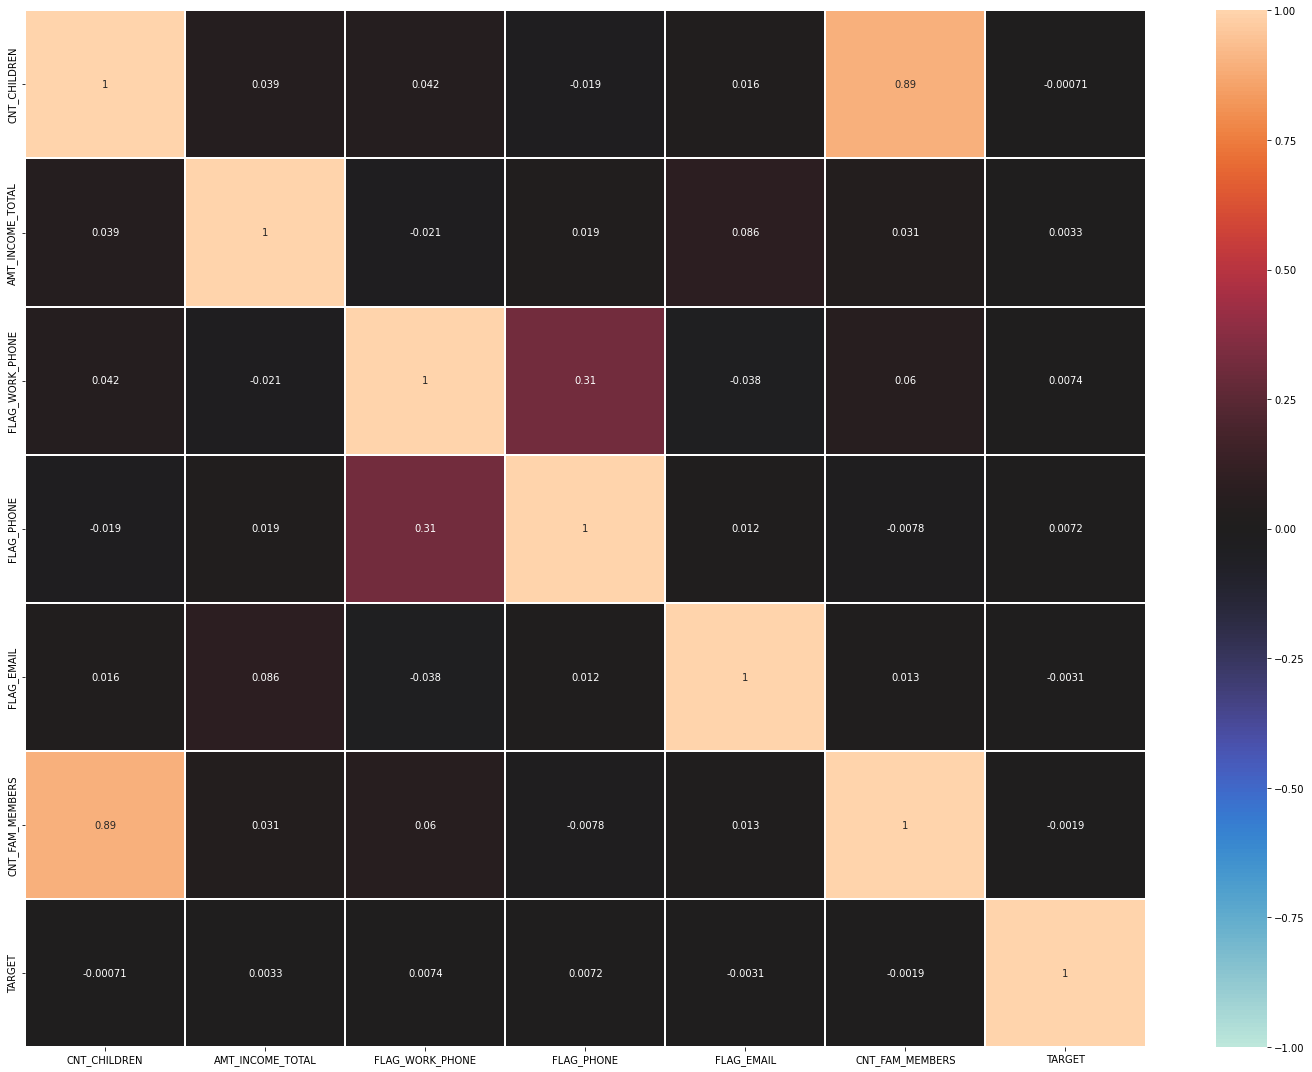

In [19]:
#Lets plot heatmap to check correlation among differnt features and label
df_corr = df.corr()
plt.figure(figsize = (20,15))
sns.heatmap(df_corr,vmin=-1,vmax=1,annot=True,center=0,fmt='.2g',linewidths=0.1)
plt.tight_layout()

# Separate features and label as x & y respectively

In [20]:
x = df.drop(columns = 'TARGET')
y = df['TARGET']

In [21]:
#lets separate numerical and categorical features for scaling and encoding
num = x._get_numeric_data()
cat = x.select_dtypes(include=['object'])

In [22]:
#Lets bring all numerical features to common scale by applying standard scaler
scaler = StandardScaler()
x_num = scaler.fit_transform(num)
x_num = pd.DataFrame(x_num,columns=num.columns)

In [23]:
#combine both numerical and categorical features
X = pd.concat([x_num,cat], axis = 1)

In [24]:
#lets have a look at our features
X.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,others
1,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,others
2,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,others
3,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,others
4,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,others


## Encoding ¶

In [25]:

#lets convert categorical data into numeric values, using OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
for i in X.columns:
    if X[i].dtypes == "object" :
        X[i] = enc.fit_transform(X[i].values.reshape(-1,1))

In [26]:
#lets have a look at data after encoding
X.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,1.0,1.0,1.0,4.0,1.0,0.0,4.0,18.0
1,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,1.0,1.0,1.0,4.0,1.0,0.0,4.0,18.0
2,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,1.0,1.0,1.0,4.0,1.0,0.0,4.0,18.0
3,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,1.0,1.0,1.0,4.0,1.0,0.0,4.0,18.0
4,-0.574026,2.351502,1.820367,-0.656158,-0.317691,-0.230155,1.0,1.0,1.0,4.0,1.0,0.0,4.0,18.0


In [27]:

#check the shape
X.shape

(777715, 14)

In [28]:

#check value count for target variable
y.value_counts()

0    774887
1      2828
Name: TARGET, dtype: int64

# Over sampling

In [29]:
#lets do oversampling using SMOTE
import imblearn
from imblearn.over_sampling import SMOTE
SM = SMOTE()
x_over,y_over = SM.fit_resample(X,y)

In [30]:
#lets check the count of target variable now
y_over.value_counts()

0    774887
1    774887
Name: TARGET, dtype: int64

# Finding Best random state

In [31]:

#Lets find the best random state using LogisticRegression
from sklearn.linear_model import LogisticRegression
max_accu = 0
max_rs = 0
for i in range(50,100):
    x_train,x_test,y_train,y_test = train_test_split(x_over,y_over,test_size = 0.25, random_state = i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    pred = LR.predict(x_test)
    acc = accuracy_score(y_test,pred)
    if acc > max_accu:
        max_accu = acc
        max_rs = i
print("Best accuracy is",max_accu,"on Random State",max_rs)

Best accuracy is 0.5750121307853522 on Random State 93


In [32]:
#lets split our data into train and test parts with best random_state
x_train,x_test,y_train,y_test = train_test_split(x_over, y_over, test_size = 0.25, random_state = 93)

# ***Model Building***

In [43]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense

In [154]:
model = Sequential()

model.add(Dense(100,activation='relu',input_dim=14))
model.add(Dense(80,activation='tanh'))
model.add(Dense(40,activation='relu'))
model.add(Dense(20,activation='relu'))

model.add(Dense(15,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [155]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 100)               1500      
                                                                 
 dense_42 (Dense)            (None, 80)                8080      
                                                                 
 dense_43 (Dense)            (None, 40)                3240      
                                                                 
 dense_44 (Dense)            (None, 20)                820       
                                                                 
 dense_45 (Dense)            (None, 15)                315       
                                                                 
 dense_46 (Dense)            (None, 5)                 80        
                                                                 
 dense_47 (Dense)            (None, 1)                

In [156]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [165]:
from pandas.core.dtypes.common import validate_all_hashable
history = model.fit(x_train,y_train,batch_size=round(len(x_train)/90),epochs=50,verbose=1,validation_split=0.2, validation_data= (x_test,y_test))

Epoch 1/50
90/90 [==============================] - 1s 9ms/step - loss: 0.1121 - accuracy: 0.9613 - val_loss: 0.0976 - val_accuracy: 0.9667
Epoch 2/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0952 - accuracy: 0.9672 - val_loss: 0.0943 - val_accuracy: 0.9684
Epoch 3/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0940 - accuracy: 0.9678 - val_loss: 0.0941 - val_accuracy: 0.9681
Epoch 4/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0937 - accuracy: 0.9678 - val_loss: 0.0936 - val_accuracy: 0.9682
Epoch 5/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0936 - accuracy: 0.9678 - val_loss: 0.0936 - val_accuracy: 0.9669
Epoch 6/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0933 - accuracy: 0.9679 - val_loss: 0.0941 - val_accuracy: 0.9678
Epoch 7/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0943 - accuracy: 0.9675 - val_loss: 0.0943 - val_accuracy: 0.9674
Epoch 8/50
90/90 [==

In [166]:
y_pred = model.predict(x_test)

12108/12108 [==============================] - 20s 2ms/step


In [167]:
pred = []
for i in y_pred:
  if i <= 0.5:
    pred.append(0)
  else:
    pred.append(1)

pred = np.array(pred)

In [168]:
np.unique(pred,return_counts=True)

(array([0, 1]), array([186193, 201251]))

In [169]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.9682741247767419

In [100]:
model.evaluate(x_test,y_test)

12108/12108 [==============================] - 27s 2ms/step - loss: 0.1725 - accuracy: 0.9344


[0.17252594232559204, 0.9344499111175537]

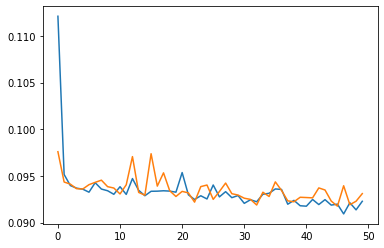

In [170]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

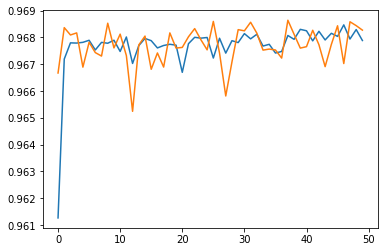

In [171]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# **THANK YOU !!!**